# Solar-System-Problem:   Energy conservation

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Solar-System-Problem">
             Initial value problem: Solar-System-Problem</a></li>

<li><a href="#Energy errors">
             Energy-errors</a></li>
             
<li><a href="#Save/Load Data">
             Save/Load-Data</a></li> 
             
<li><a href="#Plot for Juliacon2020">
            Plot-for-Juliacon2020</a></li>  

</ul>  

In the following file, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t),  where

$$
u = 
\left(\begin{matrix}
v_1 & \cdots & v_N\\
q_1 & \cdots & q_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
$$


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
$$
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
$$


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
$$
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
$$
This system of ODEs can be writen in compact form as
$$
\frac{d u}{dt} = f(t,u,Gm)
$$


We consider $N=9$ bodies of solar system: the Sun, Mercury, Venus, Earth-Moon, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

## Loading packages

In [1]:
using OrdinaryDiffEq
using DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates,LaTeXStrings
using JLD2, FileIO
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System-Problem

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/InitialNBody9.jl")

dt=6
t0=0.0
t1=10^6


u064,Gm64 =InitialNBody9(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody9(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mstep=1000
vsaveat=100.;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Int64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Energy errors

In [6]:
setprecision(BigFloat, 256)

u0256,Gm256=InitialNBody9(BigFloat)

E0=NbodyEnergy(u0256,Gm256)


-9.831951850714509861613682908577622008275351805284600444356653442764997668898217e-12

### Numerical integrations

In [7]:
sol1= solve(probdyn64,IRKGL16(mstep=mstep),adaptive=false, dt=6)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7977597
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [8]:
sol2= solve(probdyn64,IRKGL16(mstep=mstep,mixed_precision=true),adaptive=false,dt=6)
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7977597
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          166667
Number of rejected steps:                          0

In [9]:
sol11 =solve(probdyn64,Vern9(), abstol=1e-13,reltol=1e-13) #saveat=vsaveat)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8124210
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          507763
Number of rejected steps:                          0

In [10]:
sol21= solve(prob2nd64,DPRKN12(),abstol=1e-13,reltol=1e-13) #saveat=vsaveat)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  3671935
Number of function 2 evaluations:                  215997
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          215996
Number of rejected steps:                          0

In [11]:
k=1000
ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE11 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol11.u[1:k:end])./E0.-1
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u[1:k:end])./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))), Float32(maximum(abs.(ΔE21))))

(2.9031588f-16, 2.9031588f-16, 1.842958f-12, 1.13428974f-13)

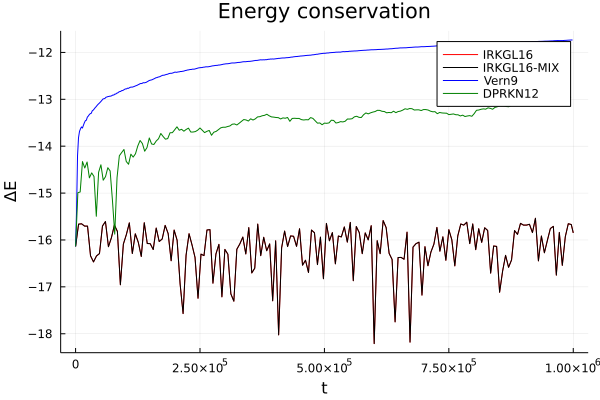

In [12]:
plot(title="Energy conservation", xlabel="t", ylabel="ΔE")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16", color="red")
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-MIX", color="black")
plot!(sol11.t[1:k:end],log10.(abs.(ΔE11)), label="Vern9", color="blue")
plot!(sol21.t[1:k:end],log10.(abs.(ΔE21)), label="DPRKN12", color="green")

<a href="#top">Back to the top</a>

## Save/Load Data

In [13]:
#save("./Data/output/OutN9BodyEnergy.jld2", "ΔE1", ΔE1, "ΔE2", ΔE2, "ΔE11", ΔE11, "ΔE21", ΔE21,     
#                                     "sol1t", sol1.t, "sol2t", sol2.t,
#                                      "sol11t", sol11.t[1:k:end], "sol21t", sol21.t[1:k:end])

## Plot for Juliacon2020

In [14]:
sol1t=load("./Data/output/OutN9BodyEnergy.jld2", "sol1t")
ΔE1=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE1")
sol21t=load("./Data/output/OutN9BodyEnergy.jld2", "sol21t")
ΔE21=load("./Data/output/OutN9BodyEnergy.jld2", "ΔE21");

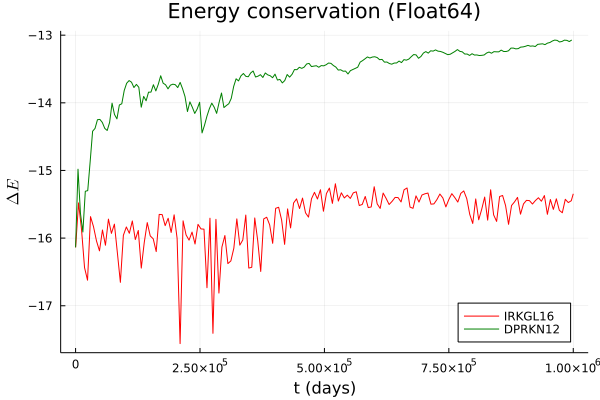

In [15]:
plot(title="Energy conservation (Float64)", xlabel="t (days)", ylabel=L"\Delta E",size= (600,400))    
plot!(sol1t,log10.(abs.(ΔE1)), label="IRKGL16", color="red",legend=:bottomright)
plot!(sol21t,log10.(abs.(ΔE21)), label="DPRKN12", color="green")

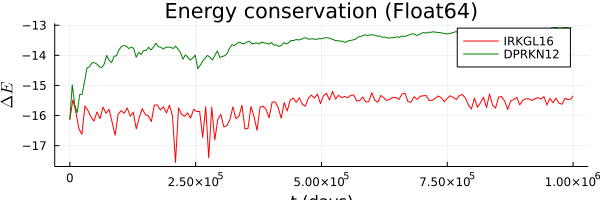

In [16]:
plot(title="Energy conservation (Float64)", xlabel="t (days)", ylabel=L"\Delta E",size= (600,200))    
plot!(sol1t,log10.(abs.(ΔE1)), label="IRKGL16", color="red")
plot!(sol21t,log10.(abs.(ΔE21)), label="DPRKN12", color="green")